# Regression
In this assignment, you are expected to use linear regression and multi layer perceptron (MLP) model to predict the metacritic score on the famous game platform, Steam.  
在本次作业中，你需要运用线性回归与多层感知机（MLP）模型，对知名游戏平台 Steam 上的游戏Metacritic 评分进行预测。  
Dataset: https://github.com/murphy-cthsu/GENAI-ML-2025-HW5-Data.git

In [1]:
# Import Modules
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Set Random Seed for Reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1115117)

In [3]:
# Preview Training Data

# 资源目录
RES_DIR = "res/hw5/"
train_df = pd.read_csv(RES_DIR + "train.csv")
# 预览资料集
row_index = 0
row = train_df.iloc[row_index]
for col, val in row.items():
    if isinstance(val, str) and len(val) > 100:
        print(f"{col:25}: {val[:100]}...")   # truncate long text
    else:
        print(f"{col:25}: {val}")
# 数值与文字特征
numeric_features = [c for c in train_df.select_dtypes(include=['number']).columns if c != 'metacritic_score']
print("All available numeric features :", numeric_features)
print("All available text features :", train_df.select_dtypes(include=['object']).columns.tolist())

appid                    : 249130
name                     : LEGO® Marvel™ Super Heroes
release_date             : 1382400000
required_age             : 0
price                    : 19.99
dlc_count                : 2
detailed_description     : LEGO® Marvel™ Super Heroes features an original story crossing the entire Marvel Universe. Players t...
about_the_game           : LEGO® Marvel™ Super Heroes features an original story crossing the entire Marvel Universe. Players t...
short_description        : LEGO® Marvel™ Super Heroes features an original story crossing the entire Marvel Universe. Players t...
reviews                  : nan
windows                  : 1
mac                      : 0
linux                    : 0
achievements             : 45
recommendations          : 18110
positive                 : 24279
negative                 : 1196
estimated_owners         : 1500000
average_playtime_forever : 0
average_playtime_2weeks  : 0
median_playtime_forever  : 0
median_playtime_2weeks

## 特征选择、模型架构及超参数

In [ ]:
# 特征选择 Feature Selection
numeric_features = ['recommendations', 'positive', 'negative', 'pct_pos_total', 'price', 'estimated_owners', ]

X_numeric = train_df[numeric_features].fillna(0).values
y = train_df['metacritic_score'].fillna(0).values.reshape(-1, 1)

# 預設只使用數值特徵
X = X_numeric

"""
# 如果想要使用embedding，可以取消以下程式碼註解
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

# 要進行embedding的文字欄位
text_columns = ['reviews','short_description']

embedder = SentenceTransformer('all-mpnet-base-v2')

def extract_embeddings(df, col):
    print(f"Embedding column: {col}")
    texts = df[col].fillna("").astype(str).tolist()
    emb = embedder.encode(texts, batch_size=64, show_progress_bar=True, convert_to_numpy=True)
    return emb

def reduce_dim_with_pca(embeddings, n_components=64):
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(embeddings)
    return reduced, pca

# 建立embeddings並用PCA降維
embeddings_reduced = []
pca_models = {}
for col in text_columns:
    emb = extract_embeddings(train_df, col)
    emb_reduced, pca_model = reduce_dim_with_pca(emb, n_components=100)
    embeddings_reduced.append(emb_reduced)
    pca_models[col] = pca_model

X_text_reduced = np.concatenate(embeddings_reduced, axis=1)

# 將數值特徵與文字特徵結合
X = np.concatenate([X_numeric, X_text_reduced], axis=1)
"""

# 对资料进行标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y)

# 切分训练与验证资料集
X_train, X_dev, y_train, y_dev = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


In [6]:
# Dataset Class
class SteamDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [7]:
# TODO(Strong baseline) - 模型架構: 自行調整模型架構以提高模型能力

# Model Class
class LinearModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.fc(x)
    
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dims=(128, 64), dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]), # 第一層：input_dim -> 128，後接ReLU，好處是能夠引入非線性，讓模型學習更複雜的模式
            nn.ReLU(),
            nn.Dropout(dropout), # 設置Dropout能夠防止overfitting
            nn.Linear(hidden_dims[0], hidden_dims[1]), # 中間層：128 -> 64，接ReLU
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[1], 1), # 輸出層：64 -> 1
        )

    def forward(self, x):
        return self.net(x)

In [103]:
# Hyperparameter
# TODO(Medium baseline) - Training Hyperparameters: 自行調整訓練超參數來改善模型表現

n_epochs = 250          # 訓練回合數
learning_rate = 2e-4     # 學習率
batch_size = 64         # 每次訓練取多少樣本
weight_decay = 1e-6        # L2 regularization強度，緩解overfitting。Useful Reference:https://medium.com/analytics-vidhya/deep-learning-basics-weight-decay-3c68eb4344e9
shuffle_data = True      # 是否在每個 epoch 打亂資料訓練

# 模型训练

Training Progress:  22%|██▏       | 54/250 [00:02<00:09, 19.78it/s]

Epoch 50: Train Loss=0.3939, Val RMSE=3.6992


Training Progress:  41%|████      | 103/250 [00:05<00:07, 19.15it/s]

Epoch 100: Train Loss=0.3879, Val RMSE=3.6863


Training Progress:  61%|██████    | 153/250 [00:07<00:05, 19.30it/s]

Epoch 150: Train Loss=0.3757, Val RMSE=3.6784


Training Progress:  81%|████████  | 203/250 [00:10<00:02, 19.73it/s]

Epoch 200: Train Loss=0.3731, Val RMSE=3.6758


Training Progress: 100%|██████████| 250/250 [00:12<00:00, 19.33it/s]

Epoch 250: Train Loss=0.3666, Val RMSE=3.6801


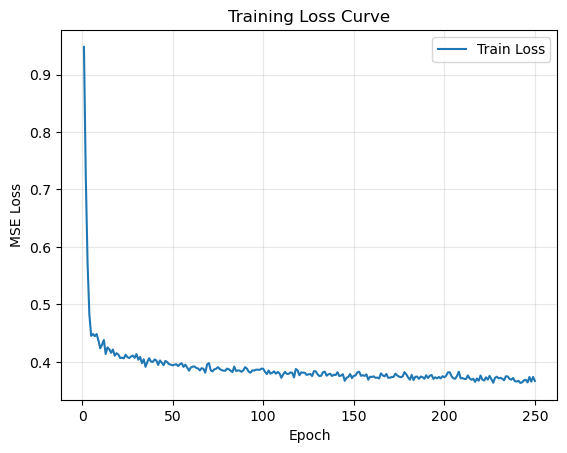

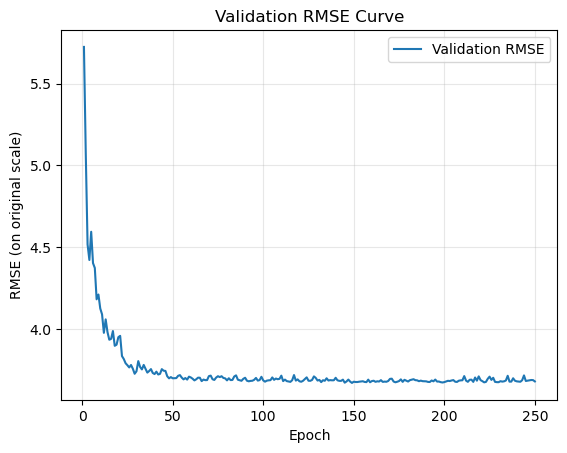

In [104]:
# 用DataLoader讀取資料集
train_set = SteamDataset(X_train, y_train)
dev_set = SteamDataset(X_dev, y_dev)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle_data)
dev_loader = DataLoader(dev_set, batch_size=batch_size, shuffle=False)

# Model / Optimizer / Loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = LinearModel(input_dim=X_train.shape[1]).to(device) 
model = MLPModel(input_dim=X_train.shape[1], hidden_dims=(128, 64), dropout=0.3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

# Training Loop
train_loss_history = []
val_rmse_history = []
for epoch in tqdm(range(n_epochs), desc="Training Progress"):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        preds = model(x_batch)
        loss = loss_fn(preds, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_loss)
    # 驗證
    model.eval()
    preds_list, y_true_list = [], []
    with torch.no_grad():
        for x_batch, y_batch in dev_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model(x_batch)
            preds_list.append(preds.cpu().numpy())  # move back to CPU for numpy
            y_true_list.append(y_batch.cpu().numpy())
    y_pred_raw = np.vstack(preds_list)
    y_true_raw = np.vstack(y_true_list)

    y_pred_inv = target_scaler.inverse_transform(y_pred_raw)
    y_true_inv = target_scaler.inverse_transform(y_true_raw)

    rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
    val_rmse_history.append(rmse)

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}: Train Loss={avg_loss:.4f}, Val RMSE={rmse:.4f}")

# Plot Training Loss and Validation RMSE
epochs = np.arange(1, n_epochs + 1)

plt.figure()
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, val_rmse_history, label="Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE (on original scale)")
plt.title("Validation RMSE Curve")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 测试

In [105]:
# 载入测试集
test_df = pd.read_csv(RES_DIR + "test.csv")
# 处理测试集特征
X_test_num = test_df[numeric_features].fillna(0).values
X_test_combined = np.hstack([X_test_num])
"""
# 如果有使用embedding，請取消以下程式碼註解
# 處理文字embedding
reviews_embed = embedder.encode(test_df["reviews"].fillna("").astype(str).tolist(),
                               batch_size=64, show_progress_bar=True, convert_to_numpy=True)
short_desc_embed = embedder.encode(test_df["short_description"].fillna("").astype(str).tolist(),
                                   batch_size=64, show_progress_bar=True, convert_to_numpy=True)

# 用train時的PCA來降維
reviews_embed_reduced = pca_models['reviews'].transform(reviews_embed)
short_desc_embed_reduced = pca_models['short_description'].transform(short_desc_embed)

# 合併numeric+embedding
X_test_combined = np.hstack([X_test_num, reviews_embed_reduced, short_desc_embed_reduced])
"""

# 用 train 的 scaler transform (跟 train 特徵維度一致)
X_test_scaled = scaler.transform(X_test_combined)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

# 模型推论
model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_tensor).cpu().numpy()
    preds = target_scaler.inverse_transform(preds_scaled).squeeze()


# 输出目录
OUTPUT_DIR = "output/hw5/"

# 保存提交结果
submission = pd.DataFrame({
    "appid": test_df["appid"],
    "metacritic_score": np.round(preds).astype(int)
})
submission.to_csv(OUTPUT_DIR + "submission.csv", index=False)